In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [8]:
# 1. LOAD DATA

In [3]:
df = pd.read_csv('../data/processed/online_retail_cleaned.csv')

In [4]:
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID       int64
Country         object
TotalPrice     float64
Year             int64
Month            int64
Day              int64
DayOfWeek        int64
DayName         object
Hour             int64
YearMonth       object
dtype: object

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df.shape

(392692, 16)

In [7]:
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [9]:
# 2. CALCULATE RFM METRICS

In [10]:
# Set analysis date (1 day after last transaction)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"\nSnapshot Date: {snapshot_date}")


Snapshot Date: 2011-12-10 12:50:00


In [11]:
# Calculate RFM for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM Metrics Summary:")
print(rfm.describe())

print("Sample RFM Data:")
print(rfm.head(10))

RFM Metrics Summary:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     306.482500
50%    15299.500000    51.000000     2.000000     668.570000
75%    16778.750000   142.000000     5.000000    1660.597500
max    18287.000000   374.000000   209.000000  280206.020000
Sample RFM Data:
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40
5       12352       36          8   2506.04
6       12353      204          1     89.00
7       12354      232          1   1079.40
8       12355    

In [12]:
# 3. RFM SCORING (1-4 scale)

In [13]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4], duplicates='drop')

# Convert to integers
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Calculate RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score_Numeric'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print("RFM Scores Distribution:")
print(rfm[['R_Score', 'F_Score', 'M_Score', 'RFM_Score_Numeric']].describe())

print("Top 10 Customers by RFM Score:")
print(rfm.nlargest(10, 'RFM_Score_Numeric')[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']])

RFM Scores Distribution:
           R_Score      F_Score      M_Score  RFM_Score_Numeric
count  4338.000000  4338.000000  4338.000000        4338.000000
mean      2.513831     2.500000     2.500000           7.513831
std       1.126296     1.118369     1.118369           2.827109
min       1.000000     1.000000     1.000000           3.000000
25%       2.000000     1.250000     1.250000           5.000000
50%       3.000000     2.500000     2.500000           7.000000
75%       4.000000     3.750000     3.750000          10.000000
max       4.000000     4.000000     4.000000          12.000000
Top 10 Customers by RFM Score:
     CustomerID  Recency  Frequency  Monetary RFM_Score
1         12347        2          7   4310.00       444
15        12362        3         10   5226.23       444
34        12388       16          6   2780.66       444
56        12417        3          9   3649.10       444
61        12423        1          8   1859.31       444
71        12433        1        

In [14]:
# 4. CUSTOMER SEGMENTATION

In [15]:
# Define segments based on RFM scores
def assign_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    # Champions: Best customers
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    
    # Loyal Customers: Buy often, spent good amount
    elif r >= 3 and f >= 4:
        return 'Loyal Customers'
    
    # Potential Loyalists: Recent customers, spent good amount, bought more than once
    elif r >= 4 and f >= 2 and m >= 3:
        return 'Potential Loyalists'
    
    # Recent Customers: Bought recently, but not often
    elif r >= 4 and f <= 2:
        return 'Recent Customers'
    
    # Promising: Recent shoppers, but haven't spent much
    elif r >= 3 and f <= 2 and m <= 2:
        return 'Promising'
    
    # Need Attention: Above average recency, frequency & monetary values
    elif r >= 3 and f >= 2 and m >= 2:
        return 'Need Attention'
    
    # About to Sleep: Below average recency, frequency & monetary values
    elif r <= 2 and f <= 2:
        return 'About to Sleep'
    
    # At Risk: Spent big money, purchased often but long time ago
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    
    # Can't Lose Them: Made biggest purchases, but haven't returned for a long time
    elif r <= 1 and f >= 4 and m >= 4:
        return "Can't Lose Them"
    
    # Hibernating: Last purchase was long back, low spenders & low number of orders
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Hibernating'
    
    # Lost: Lowest recency, frequency & monetary scores
    elif r <= 1:
        return 'Lost'
    
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)


In [17]:
# Segment summary
segment_summary = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)

segment_summary.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']
segment_summary = segment_summary.sort_values('Total_Revenue', ascending=False)

print("Customer Segments Summary:")
print(segment_summary)

print("Revenue Contribution by Segment:")
segment_summary['Revenue_Percent'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(2)
print(segment_summary[['Count', 'Total_Revenue', 'Revenue_Percent']])

Customer Segments Summary:
                     Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
Segment                                                                
Champions              489         7.42          15.53       9047.80   
Loyal Customers        422        24.44           7.94       3266.20   
At Risk                449       106.22           4.68       2128.69   
About to Sleep        1504       186.57           1.25        508.82   
Potential Loyalists    246         9.18           3.31       2263.33   
Need Attention         450        28.60           3.05       1172.17   
Promising              349        33.45           1.31        311.82   
Others                 154        70.50           2.79        468.04   
Recent Customers       183        10.26           1.45        340.66   
Lost                    92       213.53           2.92        390.85   

                     Total_Revenue  
Segment                             
Champions               4424373.61

In [18]:
# 5. VISUALIZATIONS

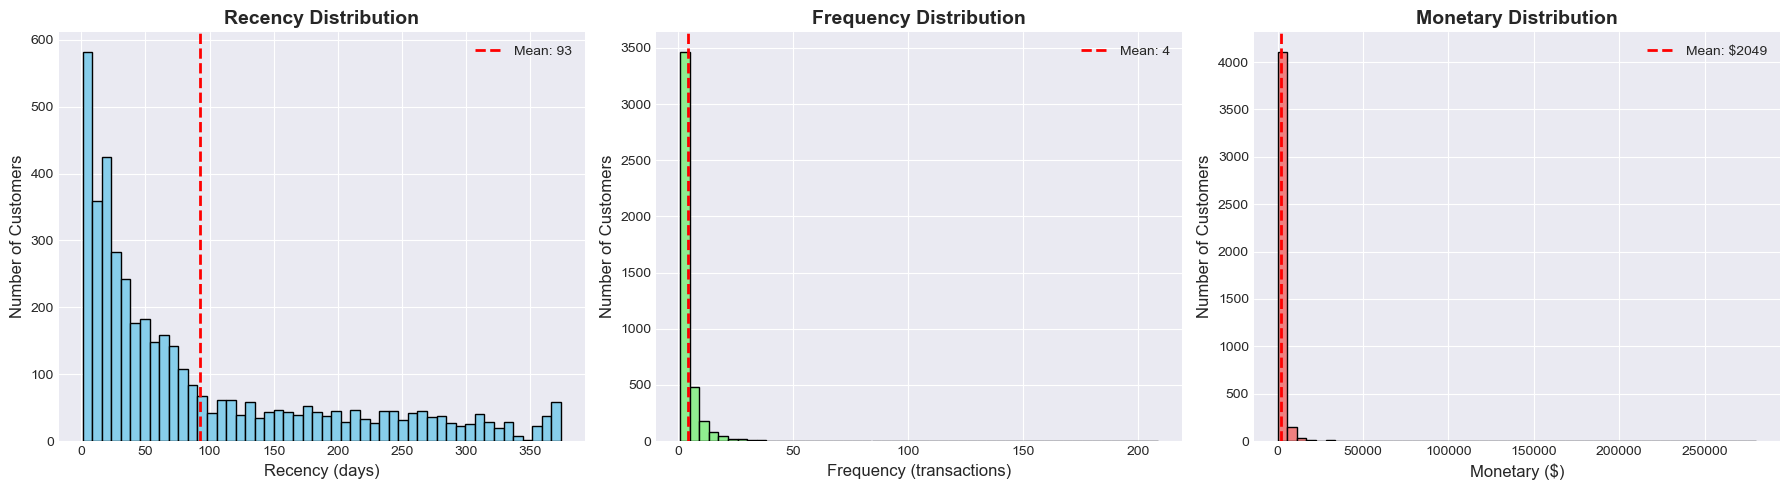

Saved: outputs/10_rfm_distribution.png


In [19]:
# 5.1 RFM Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Recency (days)', fontsize=12)
axes[0].set_ylabel('Number of Customers', fontsize=12)
axes[0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(rfm['Recency'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rfm["Recency"].mean():.0f}')
axes[0].legend()

axes[1].hist(rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Frequency (transactions)', fontsize=12)
axes[1].set_ylabel('Number of Customers', fontsize=12)
axes[1].set_title('Frequency Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(rfm['Frequency'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rfm["Frequency"].mean():.0f}')
axes[1].legend()

axes[2].hist(rfm['Monetary'], bins=50, color='lightcoral', edgecolor='black')
axes[2].set_xlabel('Monetary ($)', fontsize=12)
axes[2].set_ylabel('Number of Customers', fontsize=12)
axes[2].set_title('Monetary Distribution', fontsize=14, fontweight='bold')
axes[2].axvline(rfm['Monetary'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${rfm["Monetary"].mean():.0f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('../outputs/10_rfm_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/10_rfm_distribution.png")

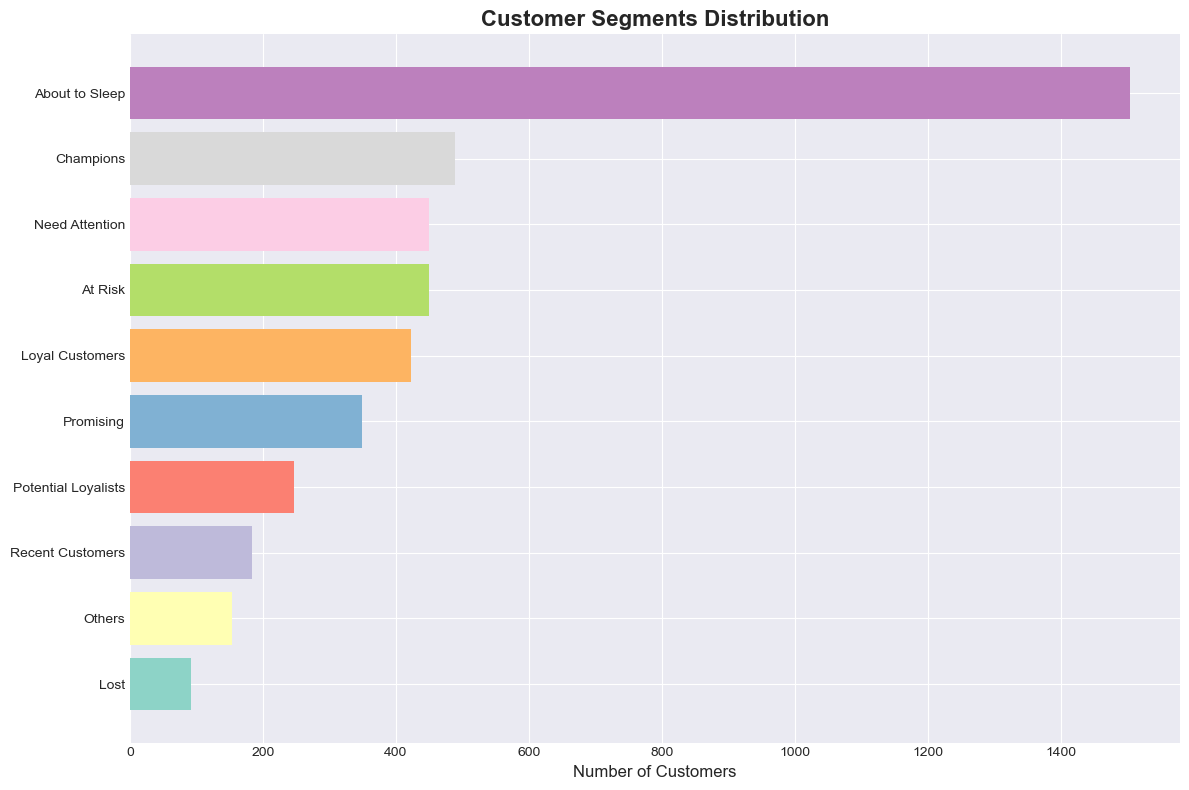

Saved: outputs/11_customer_segments.png


In [21]:
# 5.2 Customer Segments Distribution
plt.figure(figsize=(12, 8))
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=True)
colors = plt.cm.Set3(range(len(segment_counts)))
plt.barh(range(len(segment_counts)), segment_counts.values, color=colors)
plt.yticks(range(len(segment_counts)), segment_counts.index)
plt.xlabel('Number of Customers', fontsize=12)
plt.title('Customer Segments Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/11_customer_segments.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/11_customer_segments.png")

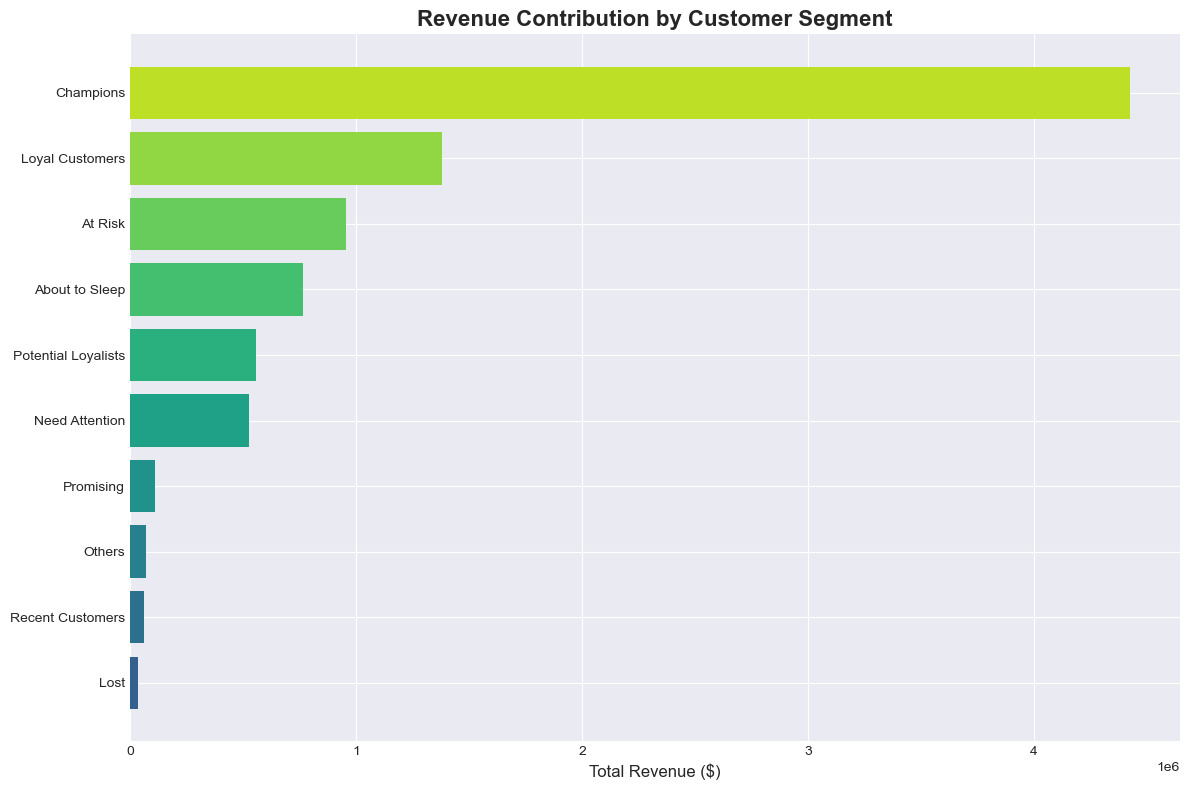

Saved: outputs/12_revenue_by_segment.png


In [22]:
# 5.3 Revenue by Segment
plt.figure(figsize=(12, 8))
segment_revenue = segment_summary.sort_values('Total_Revenue', ascending=True)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(segment_revenue)))
plt.barh(range(len(segment_revenue)), segment_revenue['Total_Revenue'], color=colors)
plt.yticks(range(len(segment_revenue)), segment_revenue.index)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.title('Revenue Contribution by Customer Segment', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/12_revenue_by_segment.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/12_revenue_by_segment.png")

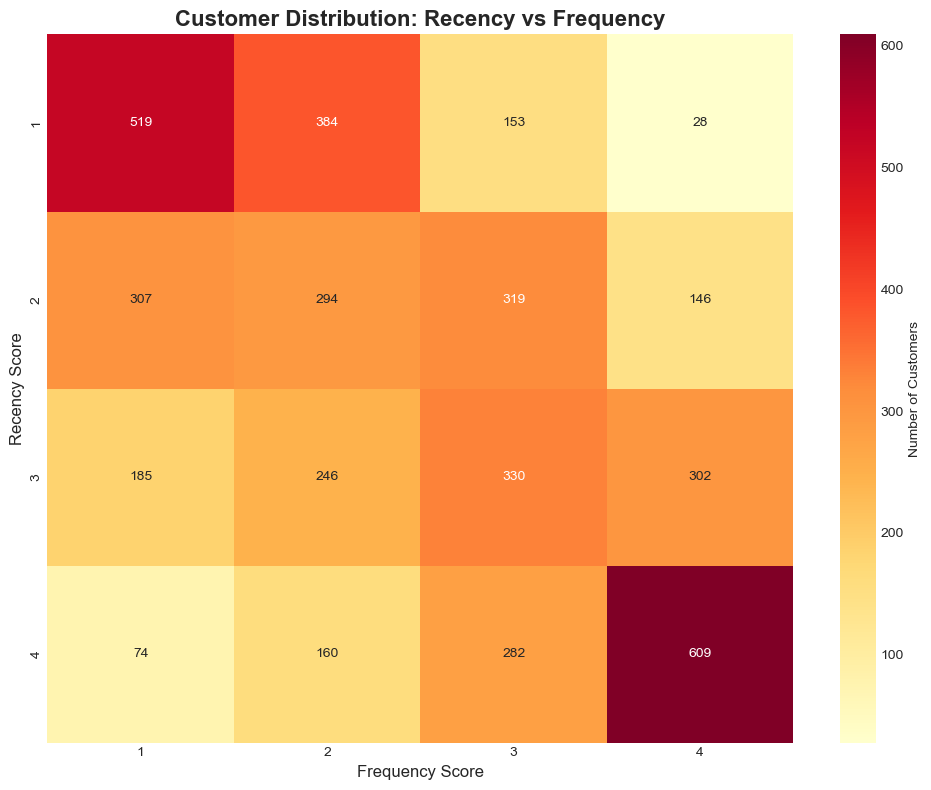

Saved: outputs/13_rfm_heatmap.png


In [23]:
# 5.4 RFM Score Heatmap (R vs F)
plt.figure(figsize=(10, 8))
rfm_pivot = rfm.pivot_table(values='CustomerID', index='R_Score', columns='F_Score', aggfunc='count', fill_value=0)
sns.heatmap(rfm_pivot, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Number of Customers'})
plt.title('Customer Distribution: Recency vs Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Frequency Score', fontsize=12)
plt.ylabel('Recency Score', fontsize=12)
plt.tight_layout()
plt.savefig('../outputs/13_rfm_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/13_rfm_heatmap.png")

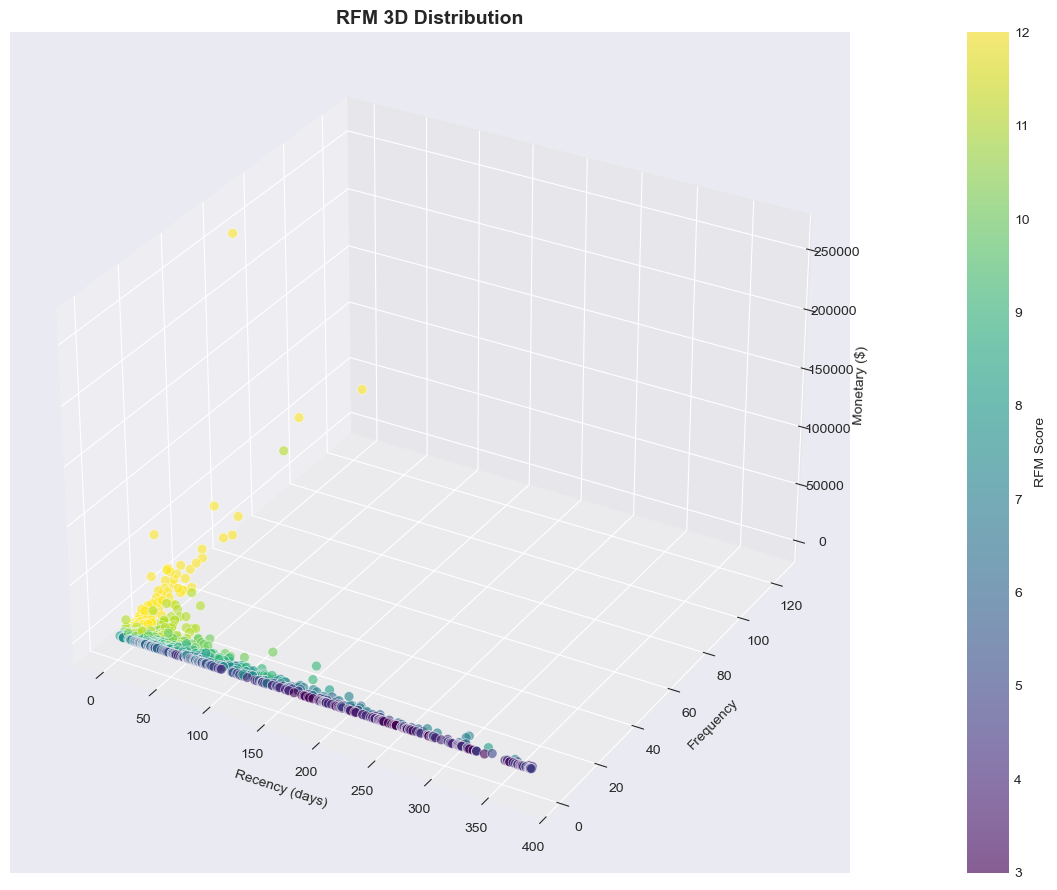

Saved: outputs/14_rfm_3d_scatter.png


In [24]:
# 5.5 3D Scatter Plot (R, F, M)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Sample data for better visualization (if too many points)
rfm_sample = rfm.sample(n=min(1000, len(rfm)), random_state=42)

scatter = ax.scatter(rfm_sample['Recency'], 
                     rfm_sample['Frequency'], 
                     rfm_sample['Monetary'],
                     c=rfm_sample['RFM_Score_Numeric'],
                     cmap='viridis',
                     s=50,
                     alpha=0.6,
                     edgecolors='w',
                     linewidth=0.5)

ax.set_xlabel('Recency (days)', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_zlabel('Monetary ($)', fontsize=10)
ax.set_title('RFM 3D Distribution', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='RFM Score', pad=0.1)
plt.tight_layout()
plt.savefig('../outputs/14_rfm_3d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/14_rfm_3d_scatter.png")

In [26]:
# 6. SAVE RFM DATA
# Save RFM with segments
rfm.to_csv('../data/processed/rfm_customer_segmentation.csv', index=False)
print("Saved: data/processed/rfm_customer_segmentation.csv")

# Save segment summary
segment_summary.to_csv('../data/processed/segment_summary.csv')
print("Saved: data/processed/segment_summary.csv")

Saved: data/processed/rfm_customer_segmentation.csv
Saved: data/processed/segment_summary.csv


In [27]:
# 7. BUSINESS RECOMMENDATIONS

In [28]:
recommendations = {
    'Champions': 'Reward them. Can be early adopters. Promote most expensive products. Ask for reviews.',
    'Loyal Customers': 'Upsell higher value products. Engage them. Ask for reviews.',
    'Potential Loyalists': 'Offer membership/loyalty program. Recommend other products.',
    'Recent Customers': 'Provide onboarding support. Start building relationship.',
    'Promising': 'Create brand awareness. Offer free trials/samples.',
    'Need Attention': 'Make limited time offers. Recommend based on past purchases. Reactivate them.',
    'About to Sleep': 'Share valuable resources. Recommend popular products. Reconnect with them.',
    'At Risk': 'Send personalized emails. Offer renewals. Provide helpful resources.',
    "Can't Lose Them": 'Win them back via renewals or newer products. Reach out personally.',
    'Hibernating': 'Offer other products and special discounts. Recreate brand value.',
    'Lost': 'Revive interest with reach out campaign. Ignore otherwise.'
}

print("\n")
for segment, recommendation in recommendations.items():
    count = len(rfm[rfm['Segment'] == segment])
    if count > 0:
        print(f"{segment} ({count} customers):")
        print(f"  {recommendation}")
        print()



Champions (489 customers):
  Reward them. Can be early adopters. Promote most expensive products. Ask for reviews.

Loyal Customers (422 customers):
  Upsell higher value products. Engage them. Ask for reviews.

Potential Loyalists (246 customers):
  Offer membership/loyalty program. Recommend other products.

Recent Customers (183 customers):
  Provide onboarding support. Start building relationship.

Promising (349 customers):
  Create brand awareness. Offer free trials/samples.

Need Attention (450 customers):
  Make limited time offers. Recommend based on past purchases. Reactivate them.

About to Sleep (1504 customers):
  Share valuable resources. Recommend popular products. Reconnect with them.

At Risk (449 customers):
  Send personalized emails. Offer renewals. Provide helpful resources.

Lost (92 customers):
  Revive interest with reach out campaign. Ignore otherwise.



In [29]:
# 8. KEY INSIGHTS

In [31]:
top_segment = segment_summary.index[0]
total_customers = len(rfm)
champions = len(rfm[rfm['Segment'] == 'Champions'])
at_risk = len(rfm[rfm['Segment'].isin(['At Risk', "Can't Lose Them", 'Hibernating', 'Lost'])])

print(f"""
1. CUSTOMER BASE:
   - Total Customers: {total_customers:,}
   - Champions: {champions} ({champions/total_customers*100:.1f}%)
   - At Risk/Lost: {at_risk} ({at_risk/total_customers*100:.1f}%)

2. TOP PERFORMING SEGMENT:
   - Segment: {top_segment}
   - Customers: {segment_summary.loc[top_segment, 'Count']:.0f}
   - Revenue: ${segment_summary.loc[top_segment, 'Total_Revenue']:,.2f} ({segment_summary.loc[top_segment, 'Revenue_Percent']:.1f}%)

3. AVERAGE METRICS:
   - Avg Recency: {rfm['Recency'].mean():.0f} days
   - Avg Frequency: {rfm['Frequency'].mean():.1f} transactions
   - Avg Monetary: ${rfm['Monetary'].mean():,.2f}

4. ACTION PRIORITIES:
   - Retain Champions and Loyal Customers
   - Reactivate At Risk customers ({at_risk} customers)
   - Convert Potential Loyalists to Loyal
""")

print("RFM Analysis completed successfully!")
print("All results saved in 'data/processed/' and 'outputs/' folders")


1. CUSTOMER BASE:
   - Total Customers: 4,338
   - Champions: 489 (11.3%)
   - At Risk/Lost: 541 (12.5%)

2. TOP PERFORMING SEGMENT:
   - Segment: Champions
   - Customers: 489
   - Revenue: $4,424,373.61 (49.8%)

3. AVERAGE METRICS:
   - Avg Recency: 93 days
   - Avg Frequency: 4.3 transactions
   - Avg Monetary: $2,048.69

4. ACTION PRIORITIES:
   - Retain Champions and Loyal Customers
   - Reactivate At Risk customers (541 customers)
   - Convert Potential Loyalists to Loyal

RFM Analysis completed successfully!
All results saved in 'data/processed/' and 'outputs/' folders
